In [1]:
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Read both of the tables
# df_1 = pd.read_csv('./CatoPDF_Spring2022_LORD.csv.dat', skiprows=6, delimiter='\t', usecols=range(0,9))
# df_2 = pd.read_csv('./CatoPDF_Spring2022_LORD.csv.dat', skiprows=6, delimiter='\t', usecols=range(9,18))
df_1 = pd.read_csv('./Airbrakes_Spring2023_LORD.csv', skiprows=6, delimiter='\t', usecols=range(0,9))
df_2 = pd.read_csv('./Airbrakes_Spring2023_LORD.csv', skiprows=6, delimiter='\t', usecols=range(9,18))

In [3]:
# Merge the dataframes
df_m = pd.merge(df_1, df_2.rename(columns={'time.1':'time'}), on='time',  how='left')

# Interpolate missing values (since we merged on different sized tables
df_m.set_index('time', inplace=True)
#df_m.interpolate(method='index', inplace=True)
df_m.bfill(inplace=True)
df_m.reset_index(inplace=True)

# Constrain time to range we care about observing

# Cato 2022 Times
# tstart = 1450
# tend = 1500.5

# Spring2023 Airbrakes
tstart = 1510
tend = 1640.5

df_m = df_m[(df_m['time'] < tend) & (df_m['time'] > tstart)]

# Visually check that things look like
print(df_m.head())

                time   accel_x   accel_y   accel_z    gyro_x    gyro_y  \
1369059  1510.000977  0.026261  0.254280  9.901452 -0.661036  0.508776   
1369060  1510.001953  0.032398  0.255633  9.859144 -0.599678  0.089585   
1369061  1510.003052  0.025660  0.276184  9.778605 -0.491191 -0.098767   
1369062  1510.004028 -0.033876  0.293474  9.863058 -0.248746 -0.012001   
1369063  1510.005005 -0.037947  0.271977  9.799832 -0.290153 -0.028035   

           gyro_z  gps  gps.1    altitude  estLinearAccelX  estLinearAccelY  \
1369059  0.181873  0.0    4.0 -133.664383         0.008233        -0.066308   
1369060  0.012088  0.0    4.0 -133.664383         0.008233        -0.066308   
1369061  0.090633  0.0    4.0 -133.664383         0.068939         0.024452   
1369062  0.116597  0.0    4.0 -133.664383         0.068939         0.024452   
1369063 -0.017929  0.0    4.0 -133.664383        -0.004224         0.048634   

         estLinearAccelZ      roll     pitch       yaw  gps.2  
1369059         

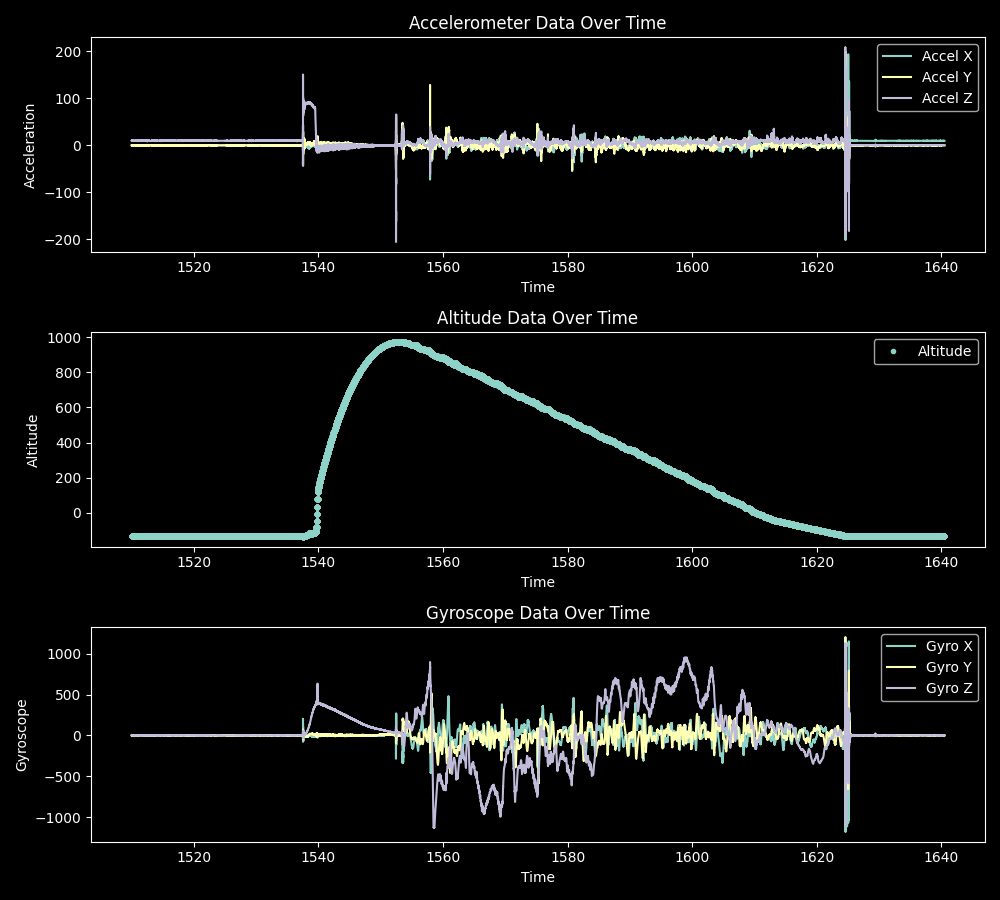

In [4]:
# Plot accelerometer data
plt.figure(figsize=(10, 9))
plt.subplot(3, 1, 1)
plt.plot(df_m['time'], df_m['accel_x'], label='Accel X')
plt.plot(df_m['time'], df_m['accel_y'], label='Accel Y')
plt.plot(df_m['time'], df_m['accel_z'], label='Accel Z')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend()
plt.title('Accelerometer Data Over Time')

# Plot Altitude data
plt.subplot(3, 1, 2)
plt.plot(df_m['time'], df_m['altitude'], '.', label='Altitude')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.legend()
plt.title('Altitude Data Over Time')

# Plot gyroscope data
plt.subplot(3, 1, 3)
plt.plot(df_m['time'], df_m['gyro_x'], label='Gyro X')
plt.plot(df_m['time'], df_m['gyro_y'], label='Gyro Y')
plt.plot(df_m['time'], df_m['gyro_z'], label='Gyro Z')
plt.xlabel('Time')
plt.ylabel('Gyroscope')
plt.legend()
plt.title('Gyroscope Data Over Time')

# Show the plot
plt.tight_layout()
plt.show()

In [5]:
import numpy as np
'''
Module / Class created for simulating the flight of a rocket using 1D motion approximations.
All unites in SI / metric unless explicitly stated otherwise
'''
class rocket_model_1D:
    itmax = 10000 #maximum number of simulation iterations

    def __init__ (self, mass, area, drag_coeff, density_model = 1, gravtiy_model = 1):
        # Define the rocket
        self.mass = mass
        self.massi = 1/mass
        self.ref_area = area # reference area for the drag coefficient
        self.Cd = drag_coeff
        self.density_model = density_model
        self.gravity_model  = gravtiy_model
        self.state = np.array([0.0,0.0]) #state = np.array([position, velocity])

    def initialize(self, position, velocity):
      self.state[0] = position
      self.state[1] = velocity

    def set_timestep(self, dt):
      self.dt = dt

    def CdA(self):
      return self.Cd * self.ref_area

    def rho(self):
      if (self.density_model == 1):
        return 1.2
      else:
        return float('NaN')

    def g(self):
      if (self.gravity_model == 1):
       return 9.81
      else:
        return float('NaN')

    def drag_force(self, velocity):
      vmag = abs(velocity)
      return 0.5*self.rho()*vmag*velocity*self.CdA()

    def acceleration(self):
      return -self.drag_force(self.state[1])*self.massi - self.g()

    def euler_step(self):
      self.state += self.dt * np.array([self.state[1], self.acceleration()])

    def sim_to_apogee(self):
      iter = 0;
      self.height = []
      self.time = []

      self.height.append(self.state[0])
      self.time.append(0)

      while (self.state[1] > 0) and (iter < self.itmax):
        self.euler_step()

        self.height.append(self.state[0])
        self.time.append(self.time[iter] + self.dt)
        iter += 1

      return self.state[0]

In [6]:
import filterpy.kalman as kf
from filterpy.kalman import KalmanFilter
import numpy as np
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise
from scipy.signal import butter, lfilter, freqz
import scipy
import mathutils
import math
import time
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures



In [7]:
time_series = df_m['time']
altitude_series = df_m['altitude']
accel_x_ser = df_m["estLinearAccelX"]
accel_y_ser = df_m["estLinearAccelY"]
accel_z_ser = df_m["estLinearAccelZ"]
gyro_x_ser = df_m["gyro_x"]
gyro_y_ser = df_m["gyro_y"]
gyro_z_ser = df_m["gyro_z"]

In [58]:

gravity_accel = -9.81 # m/s per second

rho = 1.2

def clamp(value, minVal, maxVal):
    return max(min(value,maxVal), minVal)

def getRegressionEstimate(time, altitude, apogee_estimate_max):
    quad_model = np.poly1d(np.polyfit(time, altitude, 2))

    a, b, c = quad_model.coef
    # if (a >= 0):
    #     return apogee_estimate_max
    
    vertex_x = (-b) / (2 * a)
    
    return (quad_model(vertex_x))

def getApogeeEstimate(current_alt, current_velocity, Cd, area, mass, accel_multiplier):
    # trajectory formula
    # a(x**2) + bx + c
    # (0.5 * (gravity_accel + drag_accel))(x**2) + (velo)x + (current_alt)
    # where x is time
    
    vmag = abs(current_velocity)
    drag_force = -0.5 * rho * vmag * current_velocity * Cd * area
    
    gravity_force = gravity_accel * mass
    
    # drag_accel = drag_force / mass

    # a = (0.5 * ((gravity_accel + drag_accel) * accel_multiplier))
    total_accel = (gravity_force + drag_force) / mass
    
    a = (total_accel * accel_multiplier) * 0.5
    b = current_velocity
    c = current_alt
    
    # get vertex X (-b/2a)
    vertex_x = (-b) / (2 * a)
    
    # return the y-value at that location
    return (a * (vertex_x**2)) + (b * vertex_x) + c

In [71]:
altitude_data = altitude_series.to_numpy()
time_data = time_series.to_numpy()

accel_x = accel_x_ser.to_numpy()
accel_y = accel_y_ser.to_numpy()
accel_z = accel_z_ser.to_numpy()

gyro_x = gyro_x_ser.to_numpy()
gyro_y = gyro_y_ser.to_numpy()
gyro_z = gyro_z_ser.to_numpy()

previous_alt = -1
fixed_times = []
fixed_alt = []
for index, value in enumerate(time_data):
    if altitude_data[index] != previous_alt:
        previous_alt = altitude_data[index]
        fixed_alt.append(altitude_data[index])
        fixed_times.append(value)


def FirstOrderKF(R, Q, dt):
    """ Create first order Kalman filter. 
    Specify R and Q as floats."""
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.zeros(2)
    kf.P *= np.array([[100, 0], [0, 1]])
    kf.R *= R
    kf.Q = Q_discrete_white_noise(2, dt, Q)
    kf.F = np.array([[1., dt],
                     [0., 1]])
    kf.H = np.array([[1., 0]])
    return kf

def SecondOrderKF(R_std, Q, dt, P=100):
    """ Create second order Kalman filter. 
    Specify R and Q as floats."""
    
    kf = KalmanFilter(dim_x=3, dim_z=1)
    kf.x = np.zeros(3)
    kf.P[0, 0] = P
    kf.P[1, 1] = 1
    kf.P[2, 2] = 1
    kf.R *= R_std**2
    kf.Q = Q_discrete_white_noise(3, dt, Q)
    kf.F = np.array([[1., dt, .5*dt*dt],
                     [0., 1.,       dt],
                     [0., 0.,       1.]])
    kf.H = np.array([[1., 0., 0.]])
    return kf

R, Q = 0.02, 0.09#0.08
accelR, accelQ = 0.02, 0.10

tracker = FirstOrderKF(R, Q, dt=1)
accel_kf = FirstOrderKF(accelR, accelQ, dt=1)

accel_kf.alpha = 1.01#1.0005
tracker.alpha = 1.0010#1.0005

current_time_index = 0
dt = 1

time_values = []
pos_estimates = []
vel_estimates = []

apogee_estimates = []
apogee_estimates2 = []
apogee_estimates3 = []

accel_actual_values = []
accel_estimates = []
jerk_estimates = []

orient_diff_vals = []
up_orientation = mathutils.Euler([0,0,1]).to_quaternion()


# Parameters for quadratic model
quad_mass = 20 #25     #kg
quad_area = 0.018#0.15    #m
quad_Cd = 0.23#0.023       #drag coefficient
quad_accel_multiplier = 1.22 # Not sure if fudge, need to test with more data


# Set parameters for 1D rocket model
rkt_mass = 20 #50     #kg
rxt_area = 0.018#0.07    #m
Cd = 0.23#0.9 #0.06         #drag coefficient

apogee_model_estimates = []
rocket_model = rocket_model_1D(rkt_mass, rxt_area, Cd)

loop_times = []
launch_detected = False
motor_maybe_stopped = False
motor_stopped = False
motor_stop_time = 0

regression_values = []
regression_estimate = 0
accel_deviations = []

averaged_fit_vals = []

accel_alt_estimates = []

for index, value in enumerate(fixed_times):
    start_time = time.time()
    if (index > 0):
        dt = value - fixed_times[index-1]

    # Append current time value
    time_values.append(value)

    previousAltEstimate = tracker.x[0]
    previousVelEstimate = tracker.x[1]

    # Update altitude filter
    noise = Q_discrete_white_noise(2, dt, Q)

    tracker.F = np.array([[1., dt],
                          [0., 1]])
    tracker.Q = noise
    tracker.predict()
    tracker.update(fixed_alt[index])

    
        
        
    # Get acceleration in global frame
    current_accel = mathutils.Vector((accel_x[index], accel_y[index], accel_z[index]))
    # add a - sign to current_accel if the imu is upside down like in CatoPDF_Spring2022 lol
    current_orientation = mathutils.Euler((math.radians(gyro_x[index]), 
                                           math.radians(gyro_y[index]), 
                                           math.radians(gyro_z[index])))
    current_accel.rotate(current_orientation) 
    accel_actual_values.append(current_accel.z)
    
    # Get deviance from upwards orientation
    current_quat = current_orientation.to_quaternion()
    diff = current_quat.dot(up_orientation)
    orient_diff_vals.append(diff)
    
    # Update acceleration filter
    accel_kf.F = np.array([[1., dt],
                          [0., 1]])    
    accel_kf.Q = noise
    accel_kf.predict()
    accel_kf.update(current_accel.z)
    

    # Add acceleration and jerk estimate
    accel_estimates.append(accel_kf.x[0])
    jerk_estimates.append(accel_kf.x[1])
    
    # Add time, altitude, velocity estimates
    pos_estimates.append(tracker.x[0])
    vel_estimates.append(tracker.x[1])
    #accel_alt_estimates.append(tracker.x[2])
    
    accel_deviation = np.std(accel_estimates[(index-20):])
    accel_deviations.append(accel_deviation)
    
    if not motor_stopped:
        if not launch_detected:
            if (abs(accel_kf.x[0]) > 15):
                launch_detected = True
        else:
            if (abs(accel_kf.x[0]) < 15):# and (accel_deviation < 1.5):
                if not motor_maybe_stopped:
                    motor_maybe_stopped = value
                elif (value - motor_maybe_stopped) > 1:
                    motor_stopped = True
                    motor_stop_time = value
                    print(f"motor stopped at {value}")
            else:
                motor_maybe_stopped = False

    
    # if motor_stopped:
    # Get quadratic apogee estimate
    current_apogee_est = getApogeeEstimate(tracker.x[0], tracker.x[1],
                                            quad_Cd, quad_area, quad_mass, quad_accel_multiplier)
    # current_apogee_est2 = getApogeeEstimate(tracker.x[0], tracker.x[1],
    #                                         quad_Cd, quad_area + (motor_stop_time * (value - motor_stop_time)), quad_mass, quad_accel_multiplier)
    # current_apogee_est3 = getApogeeEstimate(tracker.x[0], tracker.x[1],
    #                                         quad_Cd, quad_area, quad_mass, 1)
    # apogee_estimates2.append(current_apogee_est2)
    # apogee_estimates3.append(current_apogee_est3) 
    # else:
    #current_apogee_est = 0
    
    apogee_estimates.append(current_apogee_est)
    
    # Look at the last few values
    window = 50
    if ((index > window + 1) and motor_stopped):
        time_in_window = time_values[(index-window):]
        altitude_in_window = pos_estimates[(index-window):]
        
        regression_estimate = getRegressionEstimate(time_in_window, altitude_in_window, current_apogee_est)
           
    else:
        regression_estimate = 0
    

    regression_values.append(regression_estimate)
    
    #dev_mix_threshold = 2
    #percent_fit = 1 - clamp(fit_deviation / dev_mix_threshold, 0, 1)
    #percent_quad = 1 - percent_fit
    transition_time = 4.8 # seconds
    
    if not motor_stopped:
        quad_weight = 1.0
        fit_weight = 0.0
    else:
        time_since_stop = value - motor_stop_time
        if time_since_stop > transition_time:
            fit_weight = 1.0
            quad_weight = 0.0
        else:
            fit_weight = time_since_stop / transition_time
            quad_weight = 1.0 - fit_weight
    

    averaged_fit = np.average([current_apogee_est, regression_estimate],
                            weights=[quad_weight*2, fit_weight])#(percent_fit * regression_estimate) + (percent_quad * current_apogee_est)
    
    
    averaged_fit_vals.append(averaged_fit)
    
       
        
    # Initialize iterative model apogee estimate
    # rocket_model.initialize(tracker.x[0], tracker.x[1])
    
    # # Time step to calculate 1D rocket model (smaller increases accuracy, but slows down perf a lot)
    # rocket_model.set_timestep(1)
    
    # # Sim to apogee (time consuming step)
    # model_estimate = rocket_model.sim_to_apogee()
    # apogee_model_estimates.append(model_estimate)

    loop_times.append(time.time() - start_time)

print(np.mean(loop_times))
    
    

0.00022155780954538293


In [63]:
actual_apogee = np.max(pos_estimates)
print(actual_apogee)

976.3178967865109


In [11]:
#plt.figure(figsize=(10, 9))

#plt.plot(time_values, accel_deviations, '.', label='Acceleration Estimate stdev')
#plt.plot(time_values, regression_filter, '.', label='Mixed Apogee Estimate Filtered')
#plt.plot(time_values, apogee_estimates2, '.', label='Quadratic Apogee Estimate2')
#plt.plot(time_values, apogee_estimates3, '.', label='Quadratic Apogee Estimate3')
#plt.plot(time_values, regression_values, '.', label='Regression A')

#plt.plot(, '.',  label='Apogee Iterative Model Estimate')
plt.xlabel('Time')
plt.ylabel('Stuff')
plt.legend()
plt.title('Stuff Data Over Time')

Text(0.5, 1.0, 'Stuff Data Over Time')

Text(0.5, 1.0, 'Stuff Data Over Time')

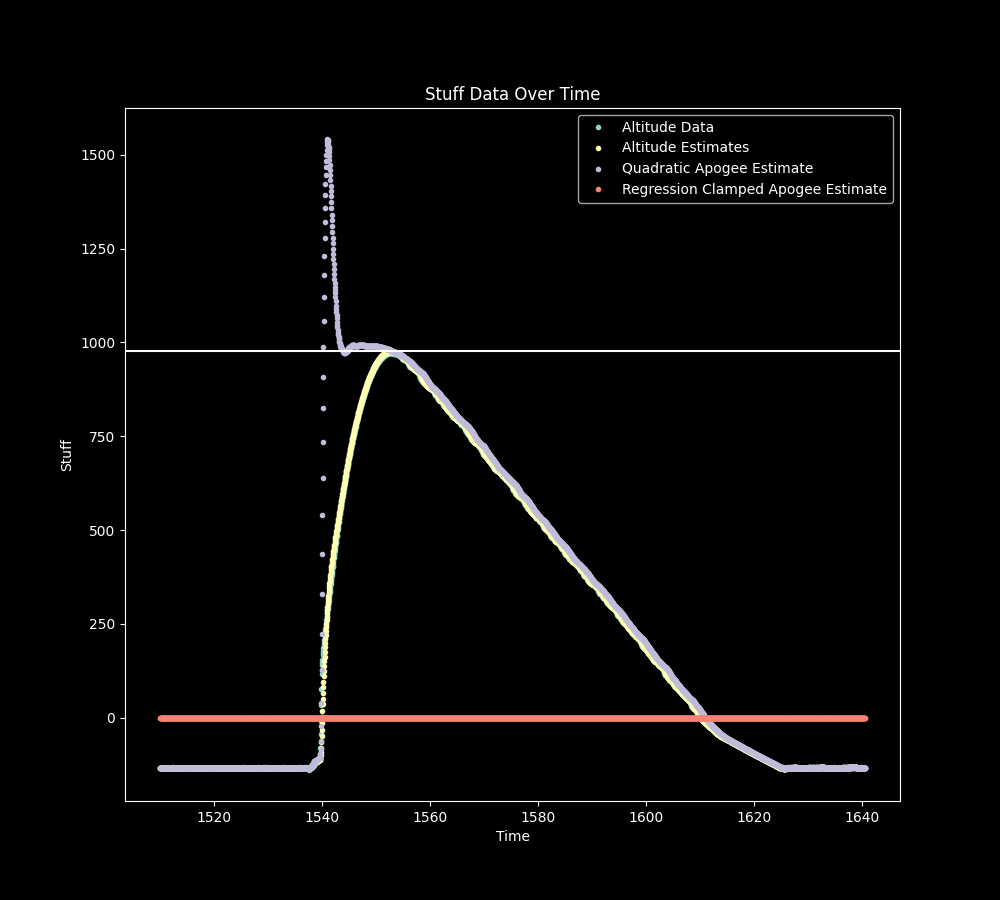

In [65]:

plt.figure(figsize=(10, 9))
#plt.subplot(2, 1, 1)
#plt.plot(time_values, altitude_data, '.', label='Altitude Data')
plt.plot(fixed_times, fixed_alt, '.',label='Altitude Data')
plt.plot(fixed_times, pos_estimates,'.', label='Altitude Estimates')
#plt.axvline(x=motor_stop_time, label='Estimated Motor Stop Time')
# plt.plot(fixed_alt[:, 1], fixed_alt[:, 0], '.', label='Fixed Altitude Data')

plt.plot(fixed_times, apogee_estimates, '.', label='Quadratic Apogee Estimate')
plt.plot(fixed_times, regression_values, '.', label='Regression Clamped Apogee Estimate')
#plt.plot(fixed_times, averaged_fit_vals, '.', label='Mixed/transition Apogee Estimate')
plt.axhline(y=actual_apogee)
# plt.plot(time_values, apogee_estimates2, '.', label='Quadratic Apogee Estimate2')
# plt.plot(time_values, apogee_estimates3, '.', label='Quadratic Apogee Estimate3')
#plt.plot(time_values, regression_values, '.', label='Regression A')

#plt.plot(, '.',  label='Apogee Iterative Model Estimate')
plt.xlabel('Time')
plt.ylabel('Stuff')
plt.legend()
plt.title('Stuff Data Over Time')

Text(0.5, 1.0, 'Stuff Data Over Time')

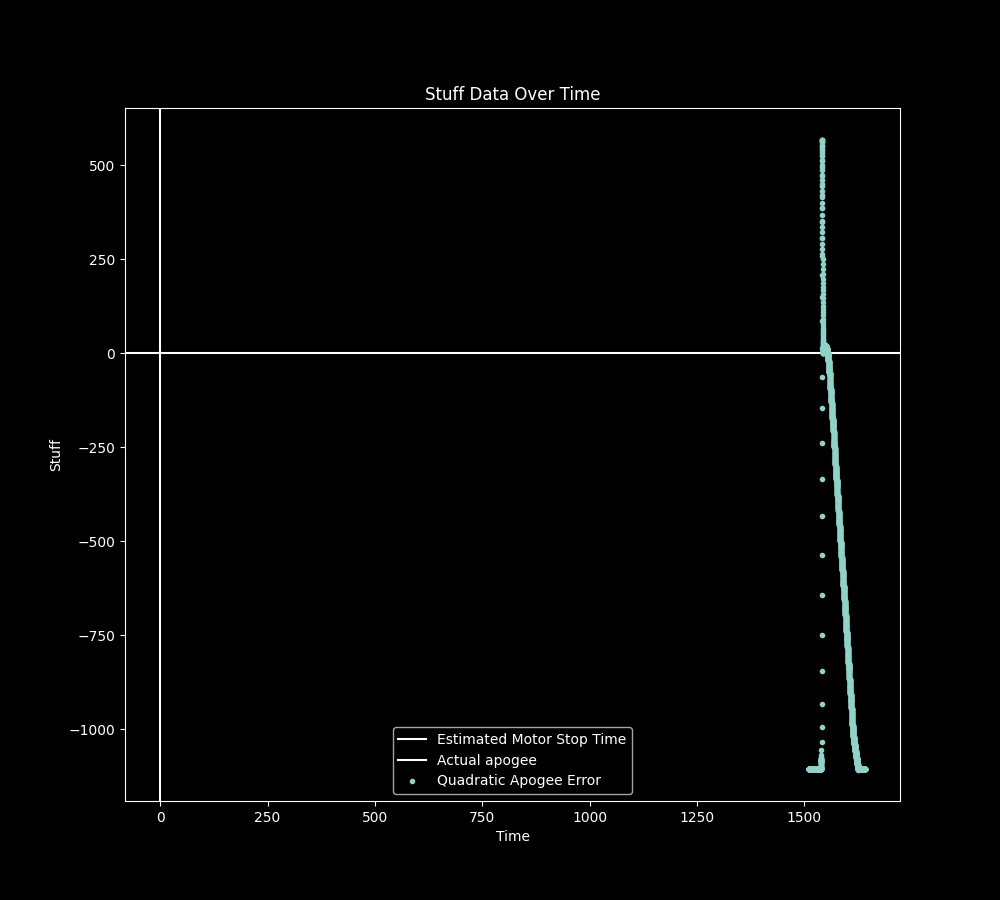

In [39]:
plt.figure(figsize=(10, 9))
#plt.subplot(2, 1, 1)
# plt.plot(time_values, altitude_data, '.', label='Altitude Data')
# plt.plot(time_values, pos_estimates, '.', label='Altitude Estimates')
plt.axvline(x=motor_stop_time, label='Estimated Motor Stop Time')
plt.axhline(y=0, label='Actual apogee')
plt.plot(time_values, np.subtract( np.asarray(apogee_estimates), actual_apogee), '.', label='Quadratic Apogee Error')
plt.plot(time_values, np.subtract( np.asarray(regression_values), actual_apogee), '.', label='Regression Clamped Apogee Error')
plt.plot(time_values, np.subtract( np.asarray(averaged_fit_vals), actual_apogee), '.', label='Mixed/transition Apogee Error')

# plt.plot(time_values, np.subtract(actual_apogee, np.asarray(apogee_estimates2)), '.', label='Quadratic Apogee Estimate2')
# plt.plot(time_values, apogee_estimates3, '.', label='Quadratic Apogee Estimate3')
#plt.plot(time_values, regression_values, '.', label='Regression A')

#plt.plot(, '.',  label='Apogee Iterative Model Estimate')
plt.xlabel('Time')
plt.ylabel('Stuff')
plt.legend()
plt.title('Stuff Data Over Time')

Text(0.5, 1.0, 'Acceleration Data Over Time')

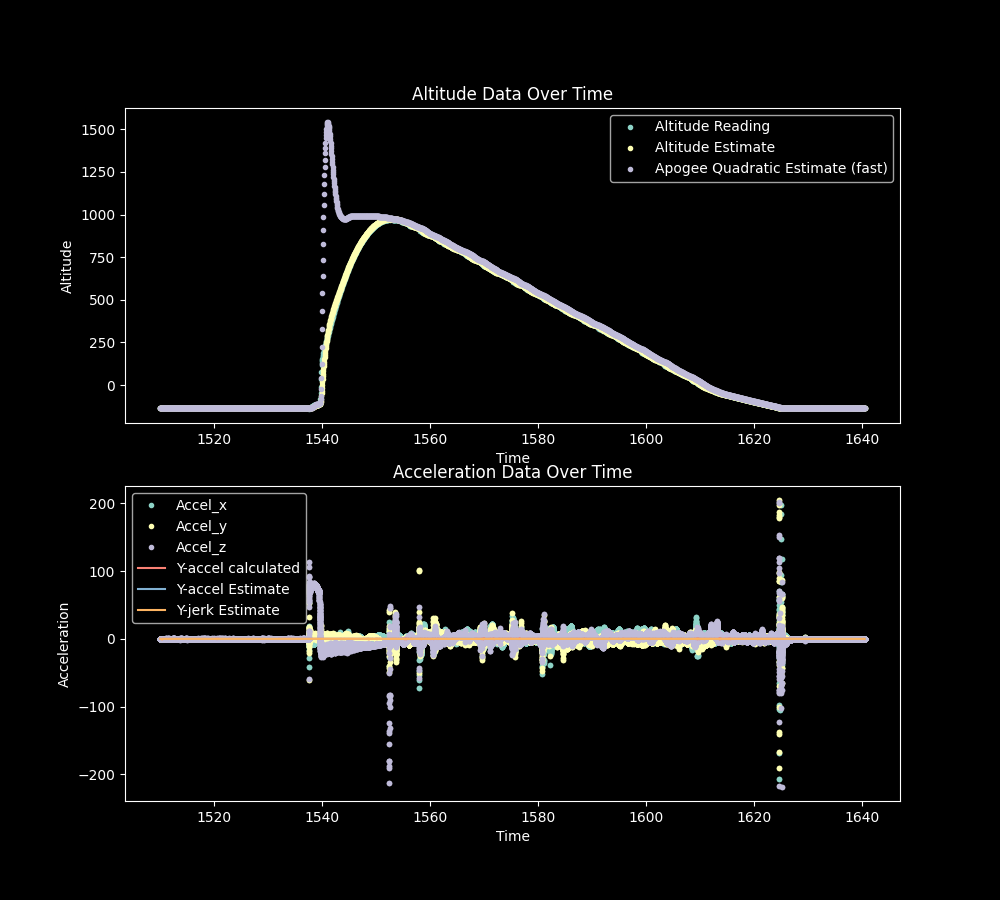

In [72]:
plt.figure(figsize=(10, 9))
plt.subplot(2, 1, 1)
plt.plot(fixed_times, fixed_alt, '.', label='Altitude Reading')
plt.plot(fixed_times, pos_estimates, '.',  label='Altitude Estimate')
plt.plot(fixed_times, apogee_estimates, '.',  label='Apogee Quadratic Estimate (fast)')
#plt.plot(time_values, apogee_model_estimates, '.',  label='Apogee Iterative Model Estimate')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.legend()
plt.title('Altitude Data Over Time')


plt.subplot(2, 1, 2)

#plt.plot(time_values, vel_estimates, '.', label='Y-velocity Estimate')

#plt.plot(time_values, orient_diff_vals, '.', label='Deviance from straight up')
plt.plot(time_data, accel_x, '.', label='Accel_x')
plt.plot(time_data, accel_y, '.', label='Accel_y')
plt.plot(time_data, accel_z, '.', label='Accel_z')
plt.plot(fixed_times, accel_actual_values, label='Y-accel calculated')
plt.plot(fixed_times, accel_estimates, label='Y-accel Estimate')
plt.plot(fixed_times, jerk_estimates, label='Y-jerk Estimate')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend()
plt.title('Acceleration Data Over Time')


Text(0.5, 1.0, 'Some Data Over Time')

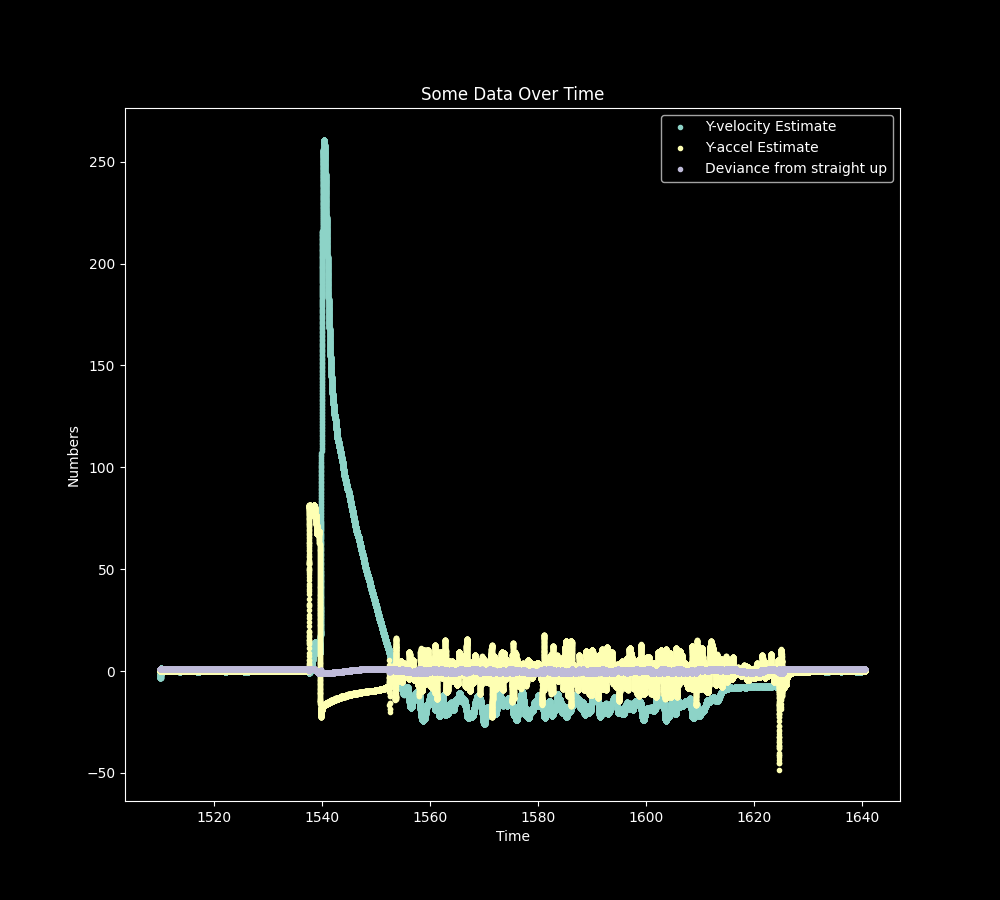

In [ ]:
plt.figure(figsize=(10, 9))
plt.plot(time_values, vel_estimates, '.', label='Y-velocity Estimate')
plt.plot(time_values, accel_estimates, '.', label='Y-accel Estimate')
plt.plot(time_values, orient_diff_vals, '.', label='Deviance from straight up')

plt.xlabel('Time')
plt.ylabel('Numbers')
plt.legend()
plt.title('Some Data Over Time')

Text(0.5, 1.0, 'Deriv_Altitude Data Over Time')

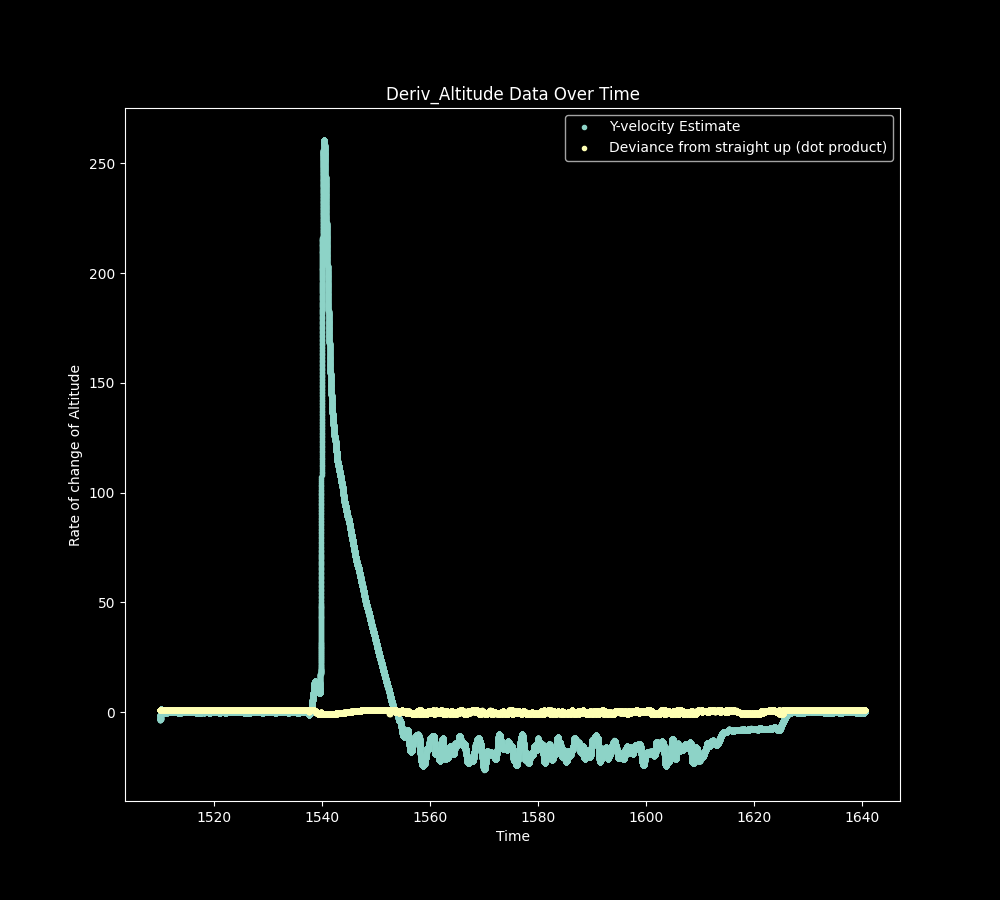

In [ ]:
plt.figure(figsize=(10, 9))
plt.plot(time_values, vel_estimates, '.', label='Y-velocity Estimate')

plt.plot(time_values, orient_diff_vals, '.', label='Deviance from straight up (dot product)')
# plt.plot(time_values, accel_x, '.', label='Accel_x')
# plt.plot(time_values, accel_y, '.', label='Accel_y')
# plt.plot(time_values, accel_z, '.', label='Accel_z')
# plt.plot(time_values, accel_estimates, '.', label='Y-accel Estimate')

plt.xlabel('Time')
plt.ylabel('Rate of change of Altitude')
plt.legend()
plt.title('Deriv_Altitude Data Over Time')
